In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping.pytorchtools import EarlyStopping

%matplotlib inline
torch.manual_seed(17)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

Files already downloaded and verified


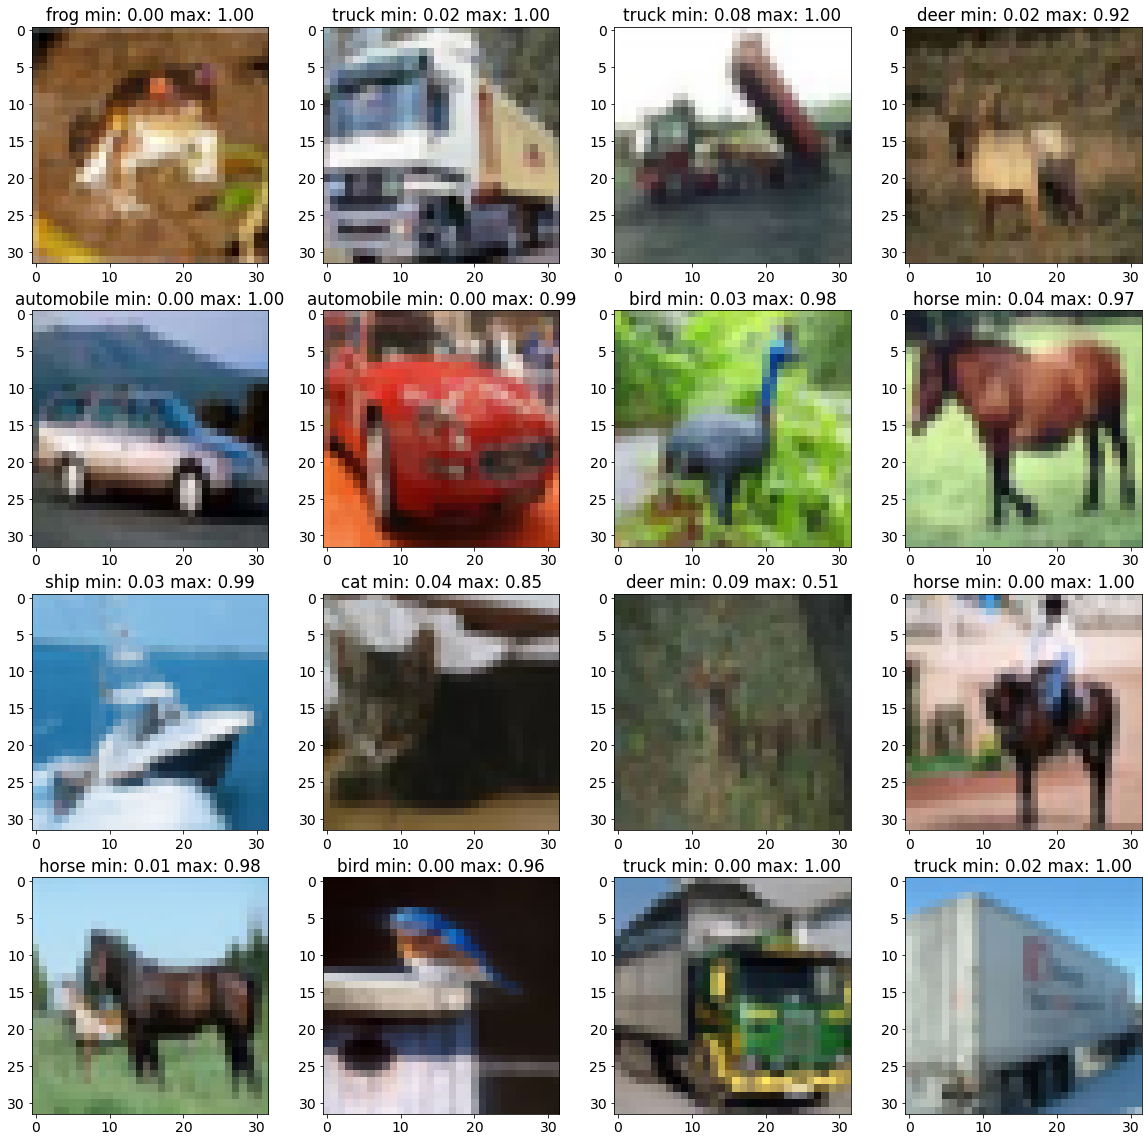

In [3]:
min_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    ])
data_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    #torchvision.transforms.RandomErasing(),
                                    #torchvision.transforms.RandomVerticalFlip(),
                                    #torchvision.transforms.RandomHorizontalFlip(),
                                    #torchvision.transforms.RandomAffine(180,
                                    #                                    translate=(0.1, 0.1),
                                    #                                    scale=(0.75,1.25))
                                    ])

dataset = torchvision.datasets.CIFAR10("/media/miro/4tb_cached/",
                                       transform=data_transform,
                                       download=True)

fig, axs = plt.subplots(4, 4,figsize=(20,20))
sample = np.random.randint(0,len(dataset),64)
for i in range(16):
    img, target = dataset.__getitem__(i)
    img = img.permute(1,2,0)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title("{} min: {:.2f} max: {:.2f}".format(dataset.classes[target],torch.min(img),torch.max(img)))

In [4]:
batch_size =  512
split = (0.25, 0.25, 0.5)
training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [5]:
#Focal LOSS!!!
def extract_weights(counts, device):
    weights = np.sum(counts)/ (counts.shape[0] * counts)
    return torch.tensor(weights,dtype=torch.float).to(device)

tensor([1.0055, 1.0096, 0.9794, 0.9945, 0.9955, 1.0390, 0.9814, 0.9867, 0.9940,
        1.0173], device='cuda:0')


Text(0.5, 1.0, 'Class Distribution')

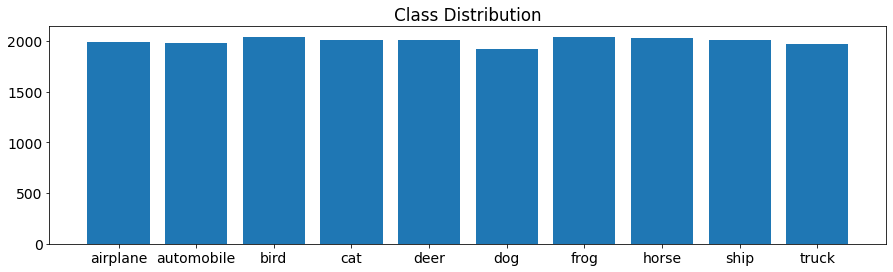

In [6]:
sample = np.random.randint(0,len(dataset),5000,dtype=np.int_)
classes_subset = dataset.targets[0:20000]
hist_val,hist_x = np.histogram(classes_subset, np.arange(0,11,1))
weights  = extract_weights(hist_val,device)
print(weights)
plt.figure(figsize=(15,4))
plt.bar(hist_x[0:len(hist_x)-1],hist_val,tick_label=dataset.classes)
plt.title("Class Distribution")

In [7]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, (3,3))

        self.conv2 = nn.Conv2d(64, 64, 3)

        self.conv3 = nn.Conv2d(64, 128, 3)


        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #batch_size x 64 x 15 x 15
        x = self.dropout1(x)
        #batch_size x 64 x 15 x 15
        x = self.pool(F.relu(self.conv2(x)))
        #batch_size x 64 x 6 x 6
        x = self.dropout1(x)
        #batch_size x 64 x 6 x 6
        x = self.pool(F.relu(self.conv3(x)))
        #batch_size x 128 x 2 x 2

        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        #batch_size x 1 x 512

        x = F.relu(self.fc1(x))
        #batch_size x 1 x 128

        x = F.relu(self.fc2(x))
        #batch_size x 1 x 64

        x = F.relu(self.fc3(x))
        #batch_size x 1 x 32

        x = self.fc4(x)
        #batch_size x 1 x 10

        return x

In [9]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs=100
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    1728    |
|  conv1.bias  |     64     |
| conv2.weight |   36864    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |   65536    |
|   fc1.bias   |    128     |
|  fc2.weight  |    8192    |
|   fc2.bias   |     64     |
|  fc3.weight  |    2048    |
|   fc3.bias   |     32     |
|  fc4.weight  |    320     |
|   fc4.bias   |     10     |
+--------------+------------+
Total Trainable Params: 188906


188906

In [10]:
plt.figure()
viz=True
avg_train_losses = []
avg_valid_losses = []
early_stopping = EarlyStopping(patience=5, verbose=True, path="net.pth")


for epoch in range(1, n_epochs + 1):
    train_losses = []
    valid_losses = []

    model.train() # prep model for training
    for input_data, classes in train_loader:
        data = input_data.to(device)
        target = classes.long().to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    for input_data, classes in valid_loader:
        data = input_data.to(device)
        target = classes.long().to(device)

        output = model(data)
        loss = criterion(output, target)
        valid_losses.append(loss.item())


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)

    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')
    print(print_msg)

    #clear_output(wait=True)

    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        #break
    model.load_state_dict(torch.load("net.pth"))

[  1/100] train_loss: 2.28614 valid_loss: 2.22245
Validation loss decreased (inf --> 2.222454).  Saving model ...
[  2/100] train_loss: 2.13027 valid_loss: 2.07832
Validation loss decreased (2.222454 --> 2.078320).  Saving model ...
[  3/100] train_loss: 2.02153 valid_loss: 1.98494
Validation loss decreased (2.078320 --> 1.984941).  Saving model ...
[  4/100] train_loss: 1.91394 valid_loss: 1.85672
Validation loss decreased (1.984941 --> 1.856720).  Saving model ...
[  5/100] train_loss: 1.83332 valid_loss: 1.81231
Validation loss decreased (1.856720 --> 1.812308).  Saving model ...
[  6/100] train_loss: 1.78783 valid_loss: 1.75815
Validation loss decreased (1.812308 --> 1.758151).  Saving model ...
[  7/100] train_loss: 1.73566 valid_loss: 1.71999
Validation loss decreased (1.758151 --> 1.719987).  Saving model ...
[  8/100] train_loss: 1.69787 valid_loss: 1.72927
EarlyStopping counter: 1 out of 5
[  9/100] train_loss: 1.72225 valid_loss: 1.73753
EarlyStopping counter: 2 out of 5
[ 10

<Figure size 432x288 with 0 Axes>

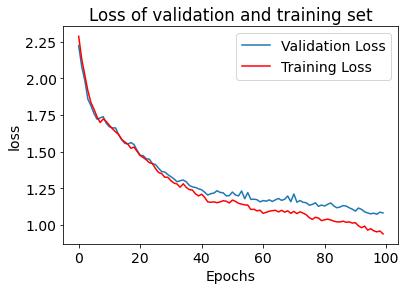

In [11]:
if viz:
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()

In [12]:
y_gts = np.array([])
y_preds = np.array([])
dataset.transform = min_transform
test_loss=[]
for input_data, classes in test_loader:
    x = input_data.to(device)
    y = classes.long().to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    _, pred = torch.max(y_pred, 1)

    y_gts = np.hstack((y_gts, y.cpu().numpy()))
    y_preds = np.hstack((y_preds, pred.cpu().numpy()))

print("Accuracy of: {}".format(np.sum(y_gts==y_preds)/y_preds.shape[0]))

Accuracy of: 0.6174


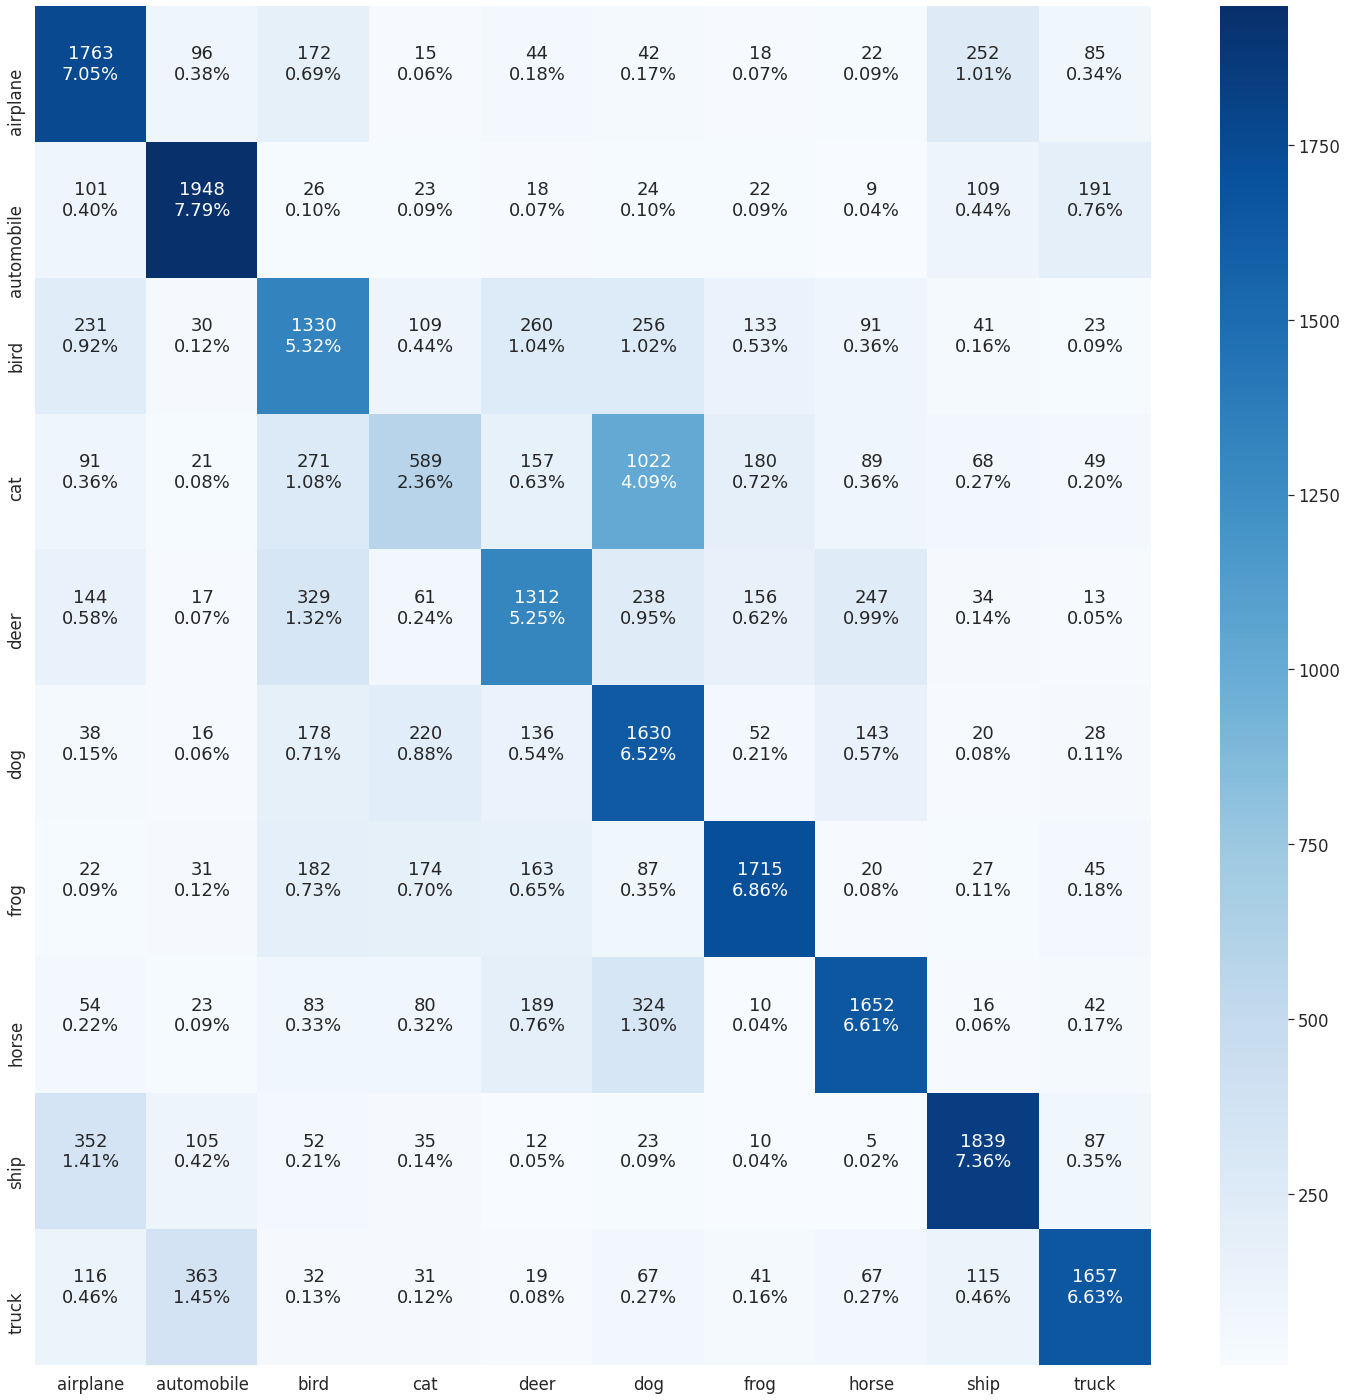

In [13]:
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

from sklearn import metrics

cm = confusion_matrix(y_gts,y_preds) #TP first
sn.set(font_scale=1.5) # for label size

plt.figure(figsize=(25,25))
group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(10,10)

ax = sn.heatmap(cm,
                annot=labels,
                fmt="",
                cmap="Blues",xticklabels=dataset.classes, yticklabels=dataset.classes,)

# 1. Premyslite si a implementujte modifikaciu ktora konzistentne zvysi accuracy.
# 2. Skuste sa dostat nad accuracy >70%.
